In [92]:
import pandas as pd
import numpy as np
import os, pickle, datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
# Load and combine the files
series = pd.read_csv('./WDISeries.csv')
series = series[['Series Code', 'Topic', 'Long definition', 
                 'Unit of measure', 'Periodicity', 'Base Period']]
countries = pd.read_csv('./WDICountry.csv')
countries.dropna(subset = ['Currency Unit'], inplace=True)
countries = countries[['Country Code', 'Short Name', 'Region', 'Income Group']]
df = pd.read_csv('./WDICSV.csv')
df = pd.merge(df, series, left_on=['Indicator Code'], right_on=['Series Code'], how='left')
df = pd.merge(df, countries, left_on=['Country Code'], right_on=['Country Code'], how='inner')

In [94]:
# Load and clean UN data
un_hdi = pd.read_excel("HDR25_Statistical_Annex_HDI_Table.xlsx", header=4)

un_hdi = un_hdi[['Unnamed: 1','Human Development Index (HDI) ']]

un_hdi.rename(columns={'Unnamed: 1': 'Country', 'Human Development Index (HDI) ':'UN HDI'}, inplace=True)
un_hdi = un_hdi.iloc[3:,:]
un_hdi = un_hdi.dropna()
un_hdi

,Country,UN HDI
3,Iceland,0.972
4,Norway,0.97
5,Switzerland,0.97
6,Denmark,0.962
7,Germany,0.959
...,...,...
217,Sub-Saharan Africa,0.568
219,Least developed countries,0.56
220,Small island developing states,0.739
222,Organisation for Economic Co-operation and Dev...,0.916


In [95]:
# Transform the data so that each metric is in its own column
metrics = [
    'Life expectancy at birth, total (years)',
    'Life expectancy at birth, female (years)',
    'Compulsory education, duration (years)',
    'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
    'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
    'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)',
    'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
    'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
    'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)',
    'GNI per capita, PPP (current international $)',
    'GDP per capita, PPP (current international $)',
    'GDP, PPP (current international $)'
]

for metric in metrics:
    df[metric] = np.where(df['Indicator Name'] == metric, df['2023'], np.nan)

    # try to fill in missing values with previous years of data
    for year in range(2022,2014,-1):
        mask = (df['Indicator Name'] == metric) & (pd.isna(df[metric]))
        df.loc[mask, metric] = df.loc[mask, f'{year}']

cols_to_keep = ['Country Code'] + metrics

df_metrics = df[cols_to_keep].groupby(['Country Code']).agg('mean').reset_index()
df_metrics.shape

(217, 13)

In [96]:
df_metrics.dropna(inplace=True)
df_metrics.shape
# 46 countries dropped due to missing data

(171, 13)

In [97]:
# Sample 100 countries from the data
df_sample = df_metrics.sample(n=100, random_state=123)

In [98]:
# Add log-income metrics
df_sample['Log_GNI per capita, PPP'] = np.log(df_sample['GNI per capita, PPP (current international $)'])
df_sample['Log_GDP, PPP'] = np.log(df_sample['GDP, PPP (current international $)'])
df_sample['Log_GDP per capita, PPP'] = np.log(df_sample['GDP per capita, PPP (current international $)'])

In [99]:
metrics.append('Log_GNI per capita, PPP')

# Apply MinMaxScaler to the metrics
scaler = MinMaxScaler()
df_relative = df_sample.copy()
df_relative[metrics] = scaler.fit_transform(df_relative[metrics])

In [100]:
# Now we use the UN cutoffs for alternative HDI estimates
df_absolute = df_sample.copy()

# https://hdr.undp.org/sites/default/files/2023-24_HDR/hdr2023-24_technical_notes.pdf
# Life expectancy cutoff is 20 to 85
for var in ['Life expectancy at birth, total (years)','Life expectancy at birth, female (years)']:
    df_absolute[var] = (df_absolute[var] - 20) / (85 - 20)

# Education is 0 to 15 years
for var in ['Compulsory education, duration (years)']:
    df_absolute[var] = (df_absolute[var] - 0) / (18 - 0)

# Education attainment is 0 to 100%
for var in ['Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
            'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
            'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)',
            'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
            'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
            'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)']:
    df_absolute[var] = (df_absolute[var] - 0) / (100 - 0)

# Log Income uses actual min and max values
for var in ['Log_GNI per capita, PPP']:
    df_absolute[var] = (df_absolute[var] - df_absolute[var].min()) / (df_absolute[var].max() - df_absolute[var].min())

In [101]:
# Average the education metrics
for df in [df_relative, df_absolute]:
    df['Avg_Education'] = df[[
        'Compulsory education, duration (years)',
        'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
        'Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)',
        'Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)'
    ]].mean(axis=1)

    df['Avg_Education_Female'] = df[[
        'Compulsory education, duration (years)',
        'Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)',
        'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)',
        'Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)'
    ]].mean(axis=1)

In [102]:
# Now take the geometric mean to get HDI estimates
for df in [df_relative, df_absolute]:
    df['HDI'] = df[['Life expectancy at birth, total (years)','Avg_Education','Log_GNI per capita, PPP']].prod(axis=1) ** (1/3)

    df['HDI_Female'] = df[['Life expectancy at birth, female (years)','Avg_Education_Female','Log_GNI per capita, PPP']].prod(axis=1) ** (1/3)

In [103]:
df_relative

,Country Code,"Life expectancy at birth, total (years)","Life expectancy at birth, female (years)","Compulsory education, duration (years)","Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)","Educational attainment, at least completed lower secondary, population 25+, total (%) (cumulative)","Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative)","Educational attainment, at least completed primary, population 25+ years, female (%) (cumulative)","Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative)","Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)","GNI per capita, PPP (current international $)","GDP per capita, PPP (current international $)","GDP, PPP (current international $)","Log_GNI per capita, PPP","Log_GDP, PPP","Log_GDP per capita, PPP",Avg_Education,Avg_Education_Female,HDI,HDI_Female
200,UGA,0.441365,0.505386,0.181818,0.839077,0.336896,0.375787,0.794909,0.301372,0.324392,0.013639,0.012913,0.004242,0.180433,25.738693,8.038395,0.433395,0.400623,0.325586,0.331812
51,DJI,0.368871,0.424947,0.454545,0.281445,0.164442,0.121600,0.224845,0.119666,0.083944,0.049471,0.042145,0.000234,0.379396,22.848521,8.890692,0.255508,0.220750,0.329451,0.328935
138,MYS,0.710376,0.760163,0.090909,0.938343,0.789244,0.716880,0.930165,0.783234,0.716824,0.274635,0.246683,0.036011,0.721752,27.877239,10.502778,0.633844,0.630283,0.687522,0.701903
144,NLD,0.878653,0.884557,0.727273,0.982818,0.913462,0.763589,0.983662,0.908464,0.749899,0.615931,0.540579,0.039409,0.894826,27.967402,11.268370,0.846785,0.842325,0.873192,0.873604
179,SUR,0.613526,0.681915,0.090909,0.689992,0.386696,0.172321,0.718265,0.434209,0.227605,0.143975,0.139469,0.000373,0.587049,23.310417,9.958712,0.334980,0.367747,0.494131,0.528021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,TCA,0.753617,0.788777,0.727273,0.954196,0.872711,0.775307,0.947828,0.866476,0.775858,0.264063,0.239107,0.000044,0.713446,21.213370,10.472679,0.832372,0.829359,0.764909,0.775686
70,GHA,0.353220,0.407445,0.545455,0.584550,0.499240,0.202013,0.542272,0.435872,0.161181,0.046324,0.044197,0.007186,0.367582,26.265766,8.930152,0.457814,0.421195,0.390268,0.398079
178,STP,0.488286,0.586011,0.090909,0.776851,0.144235,0.030850,0.798149,0.181475,0.053415,0.039383,0.034329,0.000038,0.339046,21.073819,8.724204,0.260711,0.280987,0.350777,0.382194
60,EST,0.769051,0.875297,0.363636,0.998612,0.988783,0.900063,0.999016,0.988079,0.919099,0.355096,0.319466,0.001803,0.776402,24.883961,10.753431,0.812774,0.817458,0.785846,0.822058


In [87]:
# Put the results into a df
df_relative.rename(columns={
    'HDI': 'HDI_Relative',
    'HDI_Female': 'HDI_Relative_Female'
}, inplace=True)
df_relative = df_relative[['Country Code', 'HDI_Relative', 'HDI_Relative_Female']]

df_absolute.rename(columns={
    'HDI': 'HDI_Absolute',
    'HDI_Female': 'HDI_Absolute_Female'
}, inplace=True)
df_absolute = df_absolute[['Country Code', 'HDI_Absolute', 'HDI_Absolute_Female', 'GDP, PPP (current international $)', 'Log_GDP, PPP', 'Log_GDP per capita, PPP']]

df_results = pd.merge(df_relative, df_absolute, on='Country Code', how='inner')
df_results = pd.merge(df_results, countries, on='Country Code', how='inner')

In [88]:
# Join with UN HDI data
# String cleaning for country names
df_results['Country'] = df_results['Short Name'].case_when([
    (df_results['Short Name'] == 'Bahamas, The', 'The Bahamas'),
    (df_results['Short Name'] == 'Bolivia, Plurinational State of', 'Bolivia (Plurinational State of)'),
    (df_results['Short Name'] == 'Congo, Democratic Republic of', 'Congo (Democratic Republic of the)'),
    (df_results['Short Name'] == 'Egypt, Arab Republic of', 'Egypt'),
    (df_results['Short Name'] == 'Iran, Islamic Republic of', 'Iran (Islamic Republic of)'),
    (df_results['Short Name'] == 'Kyrgyz Republic', 'Kyrgyzstan'),
    (df_results['Short Name'] == 'Lao PDR', "Lao People's Democratic Republic")
    ])
df_results = pd.merge(df_results, un_hdi, on='Country', how='left')
df_results

,Country Code,HDI_Relative,HDI_Relative_Female,HDI_Absolute,HDI_Absolute_Female,"GDP, PPP (current international $)","Log_GDP, PPP","Log_GDP per capita, PPP",Short Name,Region,Income Group,Country,UN HDI
0,UGA,0.325586,0.331812,0.408456,0.403285,1.507205e+11,25.738693,8.038395,Uganda,Sub-Saharan Africa,Low income,Uganda,0.582
1,DJI,0.329451,0.328935,0.448283,0.425175,8.375037e+09,22.848521,8.890692,Djibouti,"Middle East, North Africa, Afghanistan & Pakistan",Lower middle income,Djibouti,0.513
2,MYS,0.687522,0.701903,0.759442,0.768270,1.279178e+12,27.877239,10.502778,Malaysia,East Asia & Pacific,Upper middle income,Malaysia,0.819
3,NLD,0.873192,0.873604,0.895212,0.900048,1.399873e+12,27.967402,11.268370,Netherlands,Europe & Central Asia,High income,Netherlands,0.955
4,SUR,0.494131,0.528021,0.592030,0.608878,1.329185e+10,23.310417,9.958712,Suriname,Latin America & Caribbean,Upper middle income,Suriname,0.722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,TCA,0.764909,0.775686,0.808179,0.816696,1.632487e+09,21.213370,10.472679,Turks and Caicos Islands,Latin America & Caribbean,High income,Turks and Caicos Islands,NaN
96,GHA,0.390268,0.398079,0.507463,0.497133,2.553155e+11,26.265766,8.930152,Ghana,Sub-Saharan Africa,Lower middle income,Ghana,0.628
97,STP,0.350777,0.382194,0.453429,0.464049,1.419852e+09,21.073819,8.724204,São Tomé and Principe,Sub-Saharan Africa,Lower middle income,São Tomé and Principe,NaN
98,EST,0.785846,0.822058,0.836449,0.859458,6.411605e+10,24.883961,10.753431,Estonia,Europe & Central Asia,High income,Estonia,0.905


In [90]:
# Correlations
df_results.rename(columns={
    'GDP, PPP (current international $)': 'GDP, PPP',
    'HDI_Relative': 'HDI Relative', 
    'HDI_Relative_Female': 'HDI Relative Female', 
    'HDI_Absolute': 'HDI Absolute', 
    'HDI_Absolute_Female': 'HDI Absolute Female',  
    'Log_GDP, PPP': 'Log GDP, PPP'
    }, inplace=True)

corr = df_results[['HDI Relative', 'HDI Relative Female', 'HDI Absolute', 'HDI Absolute Female', 'UN HDI', 'GDP, PPP', 'Log GDP, PPP']].corr()
corr = corr.iloc[:,:4]

# Save the results to a tex file
corr.to_latex('./output/correlation_results.tex',
              caption='Correlation Results',
              float_format="%.3f")

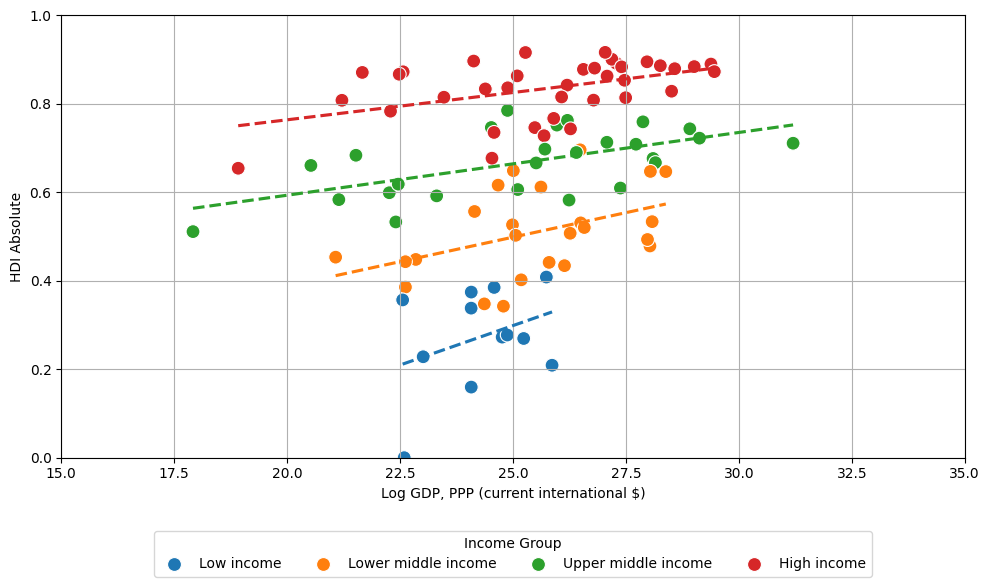

In [17]:
# Scatter plot of 'Log_GDP, PPP' vs 'HDI_Absolute'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Log_GDP, PPP', y='HDI_Absolute', hue='Income Group', s=100)

income_groups = df_results['Income Group'].unique()
palette = dict(zip(income_groups, sns.color_palette(n_colors=len(income_groups))))

for group in income_groups:
    group_data = df_results[df_results['Income Group'] == group]
    sns.regplot(
        x='Log_GDP, PPP',
        y='HDI_Absolute',
        data=group_data,
        scatter=False,
        color=palette[group],
        ci=None,
        line_kws={'linestyle': '--'}
    )

plt.xlabel('Log GDP, PPP (current international $)')
plt.ylabel('HDI Absolute')
plt.legend(title='Income Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(income_groups))
plt.ylim(0,1)
plt.xlim(15,35)
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/Scatterplot HDI Absolute.png")
plt.show()

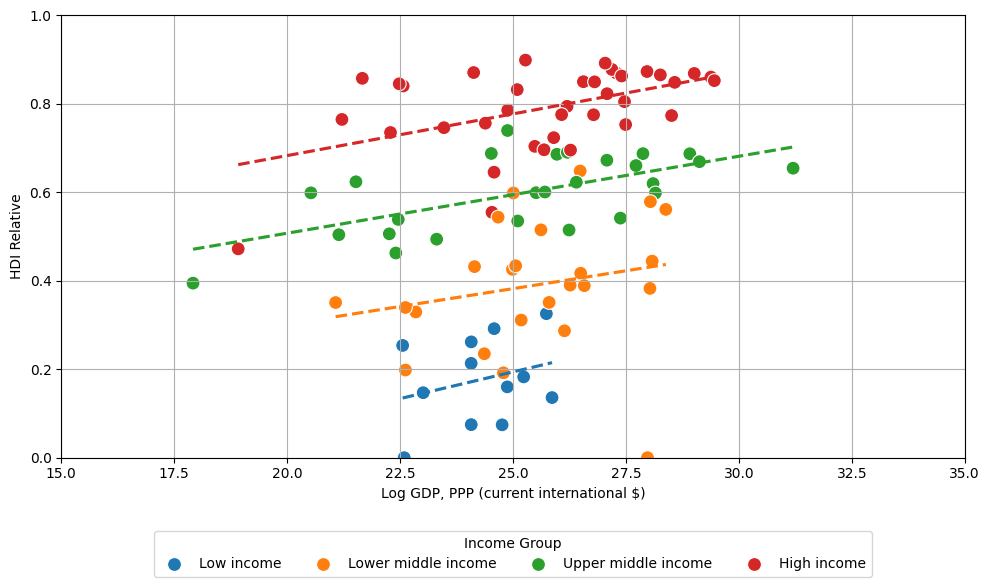

In [18]:
# Scatter plot of 'Log_GDP, PPP' vs 'HDI_Relative'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Log_GDP, PPP', y='HDI_Relative', hue='Income Group', s=100)

income_groups = df_results['Income Group'].unique()
palette = dict(zip(income_groups, sns.color_palette(n_colors=len(income_groups))))

for group in income_groups:
    group_data = df_results[df_results['Income Group'] == group]
    sns.regplot(
        x='Log_GDP, PPP',
        y='HDI_Relative',
        data=group_data,
        scatter=False,
        color=palette[group],
        ci=None,
        line_kws={'linestyle': '--'}
    )

plt.xlabel('Log GDP, PPP (current international $)')
plt.ylabel('HDI Relative')
plt.legend(title='Income Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(income_groups))
plt.ylim(0,1)
plt.xlim(15,35)
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/Scatterplot HDI Relative.png")
plt.show()

In [42]:
df_results

,Country Code,HDI_Relative,HDI_Relative_Female,HDI_Absolute,HDI_Absolute_Female,"GDP, PPP (current international $)","Log_GDP, PPP","Log_GDP per capita, PPP",Short Name,Region,Income Group
0,UGA,0.325586,0.331812,0.413595,0.408862,1.507205e+11,25.738693,8.038395,Uganda,Sub-Saharan Africa,Low income
1,DJI,0.329451,0.328935,0.460324,0.439210,8.375037e+09,22.848521,8.890692,Djibouti,"Middle East, North Africa, Afghanistan & Pakistan",Lower middle income
2,MYS,0.687522,0.701903,0.765454,0.774425,1.279178e+12,27.877239,10.502778,Malaysia,East Asia & Pacific,Upper middle income
3,NLD,0.873192,0.873604,0.907835,0.912834,1.399873e+12,27.967402,11.268370,Netherlands,Europe & Central Asia,High income
4,SUR,0.494131,0.528021,0.599610,0.616475,1.329185e+10,23.310417,9.958712,Suriname,Latin America & Caribbean,Upper middle income
...,...,...,...,...,...,...,...,...,...,...,...
95,TCA,0.764909,0.775686,0.819747,0.828469,1.632487e+09,21.213370,10.472679,Turks and Caicos Islands,Latin America & Caribbean,High income
96,GHA,0.390268,0.398079,0.517442,0.508064,2.553155e+11,26.265766,8.930152,Ghana,Sub-Saharan Africa,Lower middle income
97,STP,0.350777,0.382194,0.460331,0.471169,1.419852e+09,21.073819,8.724204,São Tomé and Principe,Sub-Saharan Africa,Lower middle income
98,EST,0.785846,0.822058,0.844689,0.867878,6.411605e+10,24.883961,10.753431,Estonia,Europe & Central Asia,High income


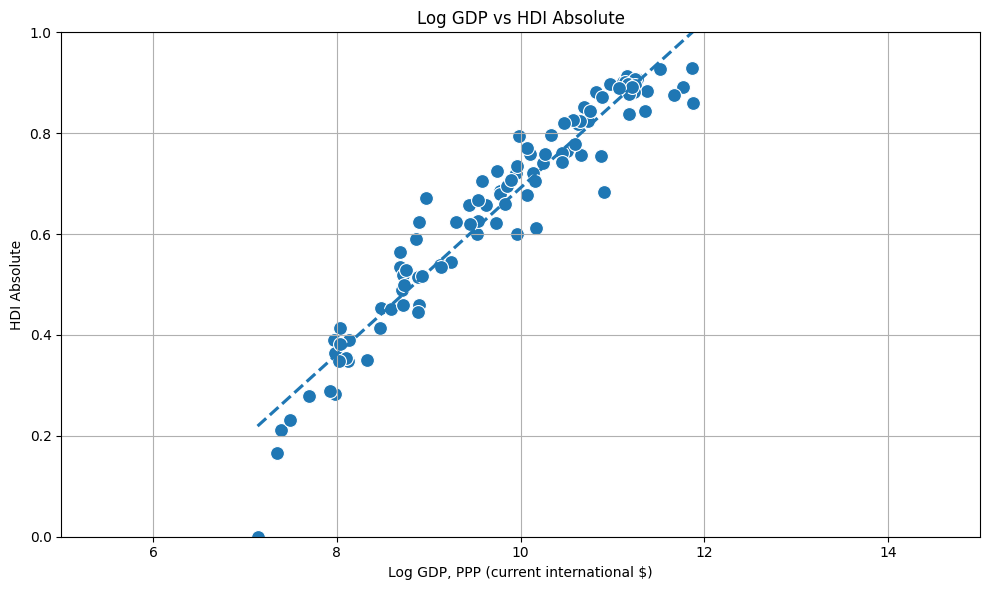

In [45]:
# Scatter plot of 'Log_GDP, PPP' vs 'HDI_Absolute'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_results, x='Log_GDP per capita, PPP', y='HDI_Absolute', s=100)
sns.regplot(
    x='Log_GDP per capita, PPP',
    y='HDI_Absolute',
    data=df_results,
    scatter=False,
    ci=None,
    line_kws={'linestyle': '--'}
)

plt.title('Log GDP vs HDI Absolute')
plt.xlabel('Log GDP, PPP (current international $)')
plt.ylabel('HDI Absolute')
plt.ylim(0,1)
plt.xlim(5,15)
plt.grid(True)
plt.tight_layout()
plt.show()

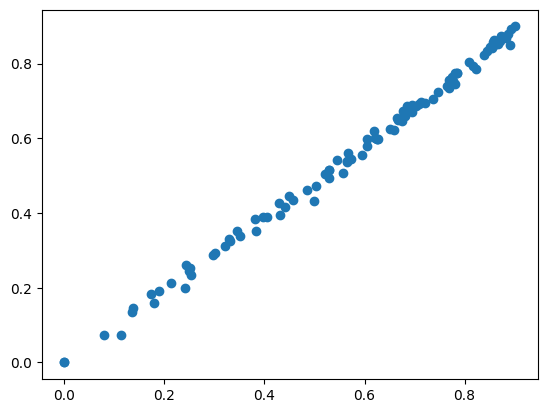

In [ ]:
plt.scatter(df_results['HDI_Relative_Female'], df_results['HDI_Relative'])

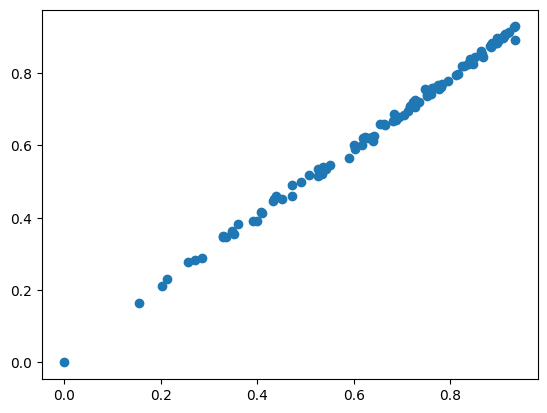

In [226]:
plt.scatter(df_results['HDI_Absolute_Female'], df_results['HDI_Absolute'])